<a href="https://colab.research.google.com/github/habdulmuhsin/habdulmuhsin/blob/main/Creating_TFRecords_for_medical_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reading the Data: ( MNIST as an example)**

I used the tf.keras.datasets.mnist.load_data function to download and read MNIST data.

*I* divided data parts by 255.0, so the final data range becomes [0,1].

I use dataType = x_train.dtype to return the data type. We need it later to read and decode the records from the TFRecord file.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train/225
x_test = x_test/225

In [ ]:
dataType = x_train.dtype
labelType = y_test.dtype

Visualization


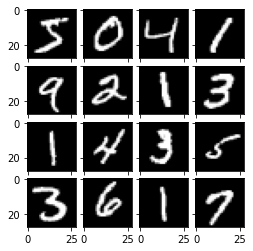

In [ ]:
im_list = []
n_samples_to_show = 16
c = 0
for i in range(n_samples_to_show):
  im_list.append(x_train[i])
# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(4., 4.))
# Ref: https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_axesgrid.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
# Show image grid
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')
plt.show()


# **Coverting our data to TFRecords:**


Here we use a protocol buffer. This is a method to change the structure of the data in a way so we can preserve it origin so we can reconstruct it from the TFRecord

This is a two step process:

A) converting the variable in our data to features that are compatible with the TFRecords:


In [ ]:
# Convert values to compatible tf.Example types.
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


B) Set the feature dictionary and structure the data with tf.train.Example as shown below:

There are two extremely important points in the  code below:

1) We store the **dimension** of the image in the structure since we need this information when reading the image so we can restructure the reconstructed image as its original shape.

2) For image, we first convert it to bytes with .tostring() or .tobytes() function (both functions does the same and .tostring() is in fact an alias for .tobytes). Then, we feed it to _bytes_feature function. Remember that even Python strings should be converted to bytes before being fed to the tf.train.BytesList.

3) Remember, in the end, we used **tf.train.Features** as it is slightly different from tf.train.Feature (*the former has one extra s letter in the end if you did not notice!!*!). tf.train.Features it’s like the wrapper of named features and takes a dictionary (called feature) as its feature argument. The dictionary keys are the feature name with values of type “tf.train.Feature”.


In [ ]:
# Create the features dictionary.
def image_example(image, label, dimension):
    feature = {
        'dimension': _int64_feature(dimension),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image.tobytes()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


# **Write Records to TFRecord File:**


```
# This is formatted as code
```


we serialize and store the structured samples in the file as shown below.

The tf.io.TFRecordWriter function is used to write a string to the specified file. The serialization is done with the SerializeToString() function. In fact, we can serialize any proto message to a binary-string by operating the SerializeToString() method.

In [ ]:
record_file = 'mnistTrain.tfrecords'
n_samples = x_train.shape[0]
dimension = x_train.shape[1]
with tf.io.TFRecordWriter(record_file) as writer:
   for i in range(n_samples):
      image = x_train[i]
      label = y_train[i]
      tf_example = image_example(image, label, dimension)
      writer.write(tf_example.SerializeToString())

## **Reading from TFRecord**
Creating the Dataset:

We use the TensorFlow tf.data API. The Tensorflow tf.data API makes the process of creating the input pipeline very handy! First, we need to read the TFRecord file and create a dataset by tf.data function:

In [ ]:
# Create the dataset object from tfrecord file(s)
dataset = tf.data.TFRecordDataset(record_file, buffer_size=100)


Retreiving Records:

Now that we have the dataset, we can loop through the dataset to extract the records. the loop below extract one sampel as we use break to stop the loop 

In [ ]:
for record in dataset:
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)
    image, label = decoded_record
    print(image.shape, label.shape)
    break

(28, 28) ()


# **Decoding:**

If we would like to loop through each record use the following code which does that and return the different features stored in the record structure based on the labels of the features. Above we have ‘dimension’, ‘label’, ‘image_raw’ features.

As we have fix length features, we use tf.io.FixedLenFeature function. If you have variable length features, you can use tf.io.FixedLenSequenceFeature function. The first argument is the shape of the input data and we set it as [].

Finally, the tf.io.parse_single_example function is used to parse the serialized record given the predetermined structure.

In [ ]:
# Decoding function
def parse_record(record):
    name_to_features = {
        'dimension': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

# **Reconstructing the Images:**

We used the dataType for the out_type argument in the tf.io.decode_raw function. It is very important. If you do NOT use the same data type, you reconstruct something inconsistent!

We used tf.reshape(image, (dimension, dimension)) as the tf.io.decode_raw have no idea about the shape! The dimension information should have been saved when we were writing to TFRecords.

In [ ]:
def decode_record(record):
    image = tf.io.decode_raw(
        record['image_raw'], out_type=dataType, little_endian=True, fixed_length=None, name=None
    )
    label = record['label']
    dimension = record['dimension']
    image = tf.reshape(image, (dimension, dimension))
    return (image, label)

    

## **Visualising the reconstructing Images:**


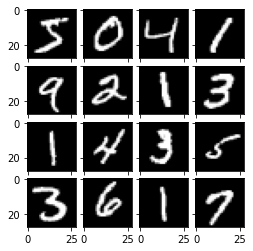

In [ ]:
im_list = []
n_samples_to_show = 16
c = 0
for record in dataset:
  c+=1
  if c > n_samples_to_show:
    break
  parsed_record = parse_record(record)
  decoded_record = decode_record(parsed_record)
  image, label = decoded_record
  im_list.append(image)
# Visualization
fig = plt.figure(figsize=(4., 4.))
# Ref: https://matplotlib.org/3.1.1/gallery/axes_grid1/simple_axesgrid.html
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
# Show image grid
for ax, im in zip(grid, im_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, 'gray')
plt.show()